# T48_v3 - Recursive FBSDE (terminal-first, normalized)
Questa versione introduce normalizzazione input per blocco, schedule terminale aggressivo e refinement automatico.



=== Recursive training (backward in time) ===
[RecursiveConfig] label=main:terminal_first, N_total=480, n_blocks=24 (req=24), min_steps_per_block=12, terminal_min_steps=28, iters_per_block=280, lr=8.0e-05, warm_start=True, train_scen=8, eval_scen=3
[RecursivePartition] label=main:terminal_first, steps=[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 12, 28]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9

[InitOutputBias] main:terminal_first b=23, bias_old=0.000, bias_target=-70.715, bias_new=-70.715
[RecursiveBlock] main:terminal_first b=23, idx=[452,480], steps=28, terminal=g, iters=2800, lr=2.8e-05
[TerminalSchedule] main:terminal_first b=23: stage1(iters=1540, lr=4.5e-05), stage2(iters=1260, lr=2.8e-05)
It: 0, Loss: 1.080e+07, Y0_mean: -70.712, Y0_std: 0.011, Time: 7.75, Learning Rate: 4.480e-05
It: 10, Loss: 1.080e+07, Y0_mean: -70.712, Y0_std: 0.0

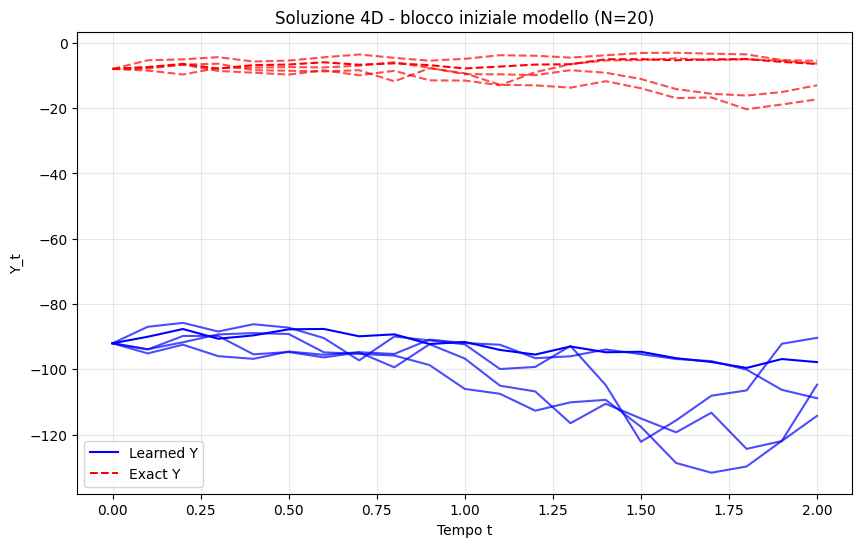

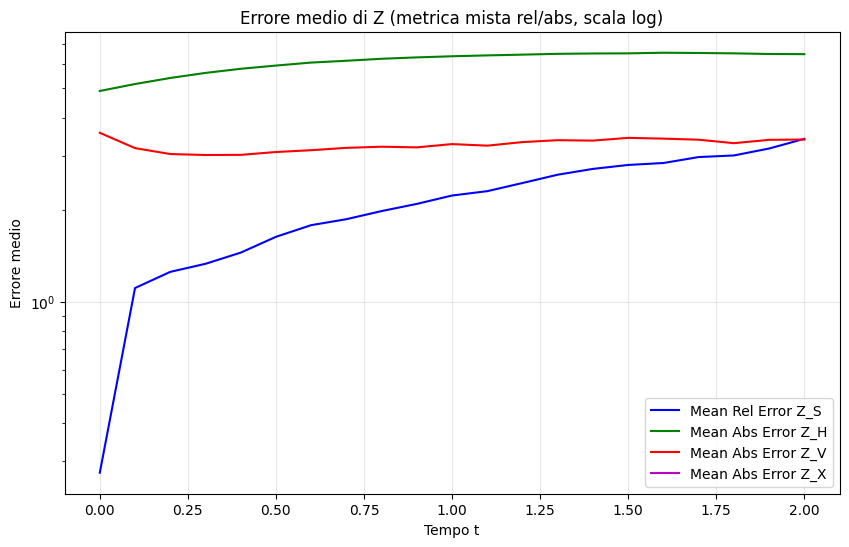

In [ ]:
import time
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()


class FBSNN(ABC):
    def __init__(
        self,
        Xi,
        T,
        M,
        N,
        D,
        layers,
        t_start=0.0,
        activation="sin",
        clip_grad_norm=1.0,
        use_antithetic_sampling=True,
        path_loss_weight=1.0,
        terminal_y_loss_weight=10.0,
        terminal_z_loss_weight=1.0,
        x_norm_mean=None,
        x_norm_std=None,
        normalize_time=True,
    ):
        self.T = float(T)
        self.t_start = np.float32(t_start)
        self.M = int(M)
        self.N = int(N)
        self.D = int(D)
        self.layers = layers

        self.activation = activation
        self.clip_grad_norm = clip_grad_norm
        self.use_antithetic_sampling = bool(use_antithetic_sampling)
        self.path_loss_weight = float(path_loss_weight)
        self.terminal_y_loss_weight = float(terminal_y_loss_weight)
        self.terminal_z_loss_weight = float(terminal_z_loss_weight)
        self.normalize_time = bool(normalize_time)

        if x_norm_mean is None:
            x_norm_mean = np.zeros((1, self.D), dtype=np.float32)
        if x_norm_std is None:
            x_norm_std = np.ones((1, self.D), dtype=np.float32)

        x_norm_mean = np.asarray(x_norm_mean, dtype=np.float32).reshape(1, self.D)
        x_norm_std = np.asarray(x_norm_std, dtype=np.float32).reshape(1, self.D)
        x_norm_std = np.maximum(x_norm_std, 1.0e-3).astype(np.float32)

        self.x_norm_mean_np = x_norm_mean
        self.x_norm_std_np = x_norm_std

        self.Xi = self._prepare_Xi(Xi)

        self.weights, self.biases = self.initialize_NN(layers)

        self.sess = tf.Session(
            config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
        )

        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        self.t_tf = tf.placeholder(tf.float32, shape=[self.M, self.N + 1, 1])
        self.W_tf = tf.placeholder(tf.float32, shape=[self.M, self.N + 1, self.D])
        self.Xi_tf = tf.placeholder(tf.float32, shape=[self.M, self.D])
        self.const_tf = tf.placeholder(tf.float32, shape=[])

        self.use_external_terminal_tf = tf.placeholder_with_default(np.float32(0.0), shape=[])
        self.Y_terminal_tf = tf.placeholder_with_default(
            tf.zeros([self.M, 1], dtype=tf.float32), shape=[self.M, 1]
        )
        self.Z_terminal_tf = tf.placeholder_with_default(
            tf.zeros([self.M, self.D], dtype=tf.float32), shape=[self.M, self.D]
        )
        self.path_loss_weight_tf = tf.placeholder_with_default(
            np.float32(self.path_loss_weight), shape=[]
        )
        self.terminal_y_loss_weight_tf = tf.placeholder_with_default(
            np.float32(self.terminal_y_loss_weight), shape=[]
        )
        self.terminal_z_loss_weight_tf = tf.placeholder_with_default(
            np.float32(self.terminal_z_loss_weight), shape=[]
        )

        self.x_norm_mean_tf = tf.constant(self.x_norm_mean_np, dtype=tf.float32)
        self.x_norm_std_tf = tf.constant(self.x_norm_std_np, dtype=tf.float32)
        self.t_start_tf = tf.constant(np.float32(self.t_start), dtype=tf.float32)
        self.t_scale_tf = tf.constant(np.float32(max(self.T, 1.0e-6)), dtype=tf.float32)

        self.loss, self.X_pred, self.Y_pred, self.Y0_pred, self.Z_pred = self.loss_function(
            self.t_tf, self.W_tf, self.Xi_tf
        )

        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        grads_and_vars = self.optimizer.compute_gradients(self.loss)
        if self.clip_grad_norm is not None:
            non_null = [(g, v) for g, v in grads_and_vars if g is not None]
            if non_null:
                grads, vars_ = zip(*non_null)
                clipped_grads, _ = tf.clip_by_global_norm(grads, self.clip_grad_norm)
                clipped = list(zip(clipped_grads, vars_))
                untouched = [(g, v) for g, v in grads_and_vars if g is None]
                grads_and_vars = clipped + untouched
        self.train_op = self.optimizer.apply_gradients(grads_and_vars)

        self.sess.run(tf.global_variables_initializer())

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2.0 / (in_dim + out_dim))
        return tf.Variable(
            tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32
        )

    def _prepare_Xi(self, Xi_in):
        Xi_arr = np.asarray(Xi_in, dtype=np.float32)
        if Xi_arr.ndim == 1:
            Xi_arr = Xi_arr.reshape(1, -1)

        if Xi_arr.shape == (1, self.D):
            Xi_arr = np.repeat(Xi_arr, self.M, axis=0)
        elif Xi_arr.shape != (self.M, self.D):
            raise ValueError(
                f"Xi must have shape (1,{self.D}) or ({self.M},{self.D}), got {Xi_arr.shape}"
            )
        return Xi_arr

    def _prepare_terminal_targets(self, Y_terminal, Z_terminal):
        Y_arr = np.asarray(Y_terminal, dtype=np.float32)
        Z_arr = np.asarray(Z_terminal, dtype=np.float32)

        if Y_arr.ndim == 1:
            Y_arr = Y_arr.reshape(-1, 1)
        if Z_arr.ndim == 1:
            Z_arr = Z_arr.reshape(1, -1)

        if Y_arr.shape != (self.M, 1):
            raise ValueError(f"Y_terminal must have shape ({self.M},1), got {Y_arr.shape}")
        if Z_arr.shape != (self.M, self.D):
            raise ValueError(f"Z_terminal must have shape ({self.M},{self.D}), got {Z_arr.shape}")

        return Y_arr, Z_arr

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = X
        for l in range(num_layers - 2):
            W = weights[l]
            b = biases[l]
            pre = tf.add(tf.matmul(H, W), b)
            if self.activation == "sin":
                H = tf.sin(pre)
            elif self.activation == "tanh":
                H = tf.tanh(pre)
            elif self.activation == "swish":
                H = pre * tf.sigmoid(pre)
            else:
                raise ValueError(
                    f"Unsupported activation '{self.activation}'. Use: sin, tanh, swish"
                )

        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, t, X):
        if self.normalize_time:
            t_in = 2.0 * ((t - self.t_start_tf) / self.t_scale_tf) - 1.0
        else:
            t_in = t
        X_in = (X - self.x_norm_mean_tf) / self.x_norm_std_tf
        u = self.neural_net(tf.concat([t_in, X_in], 1), self.weights, self.biases)
        Du = tf.gradients(u, X)[0]
        return u, Du

    def Dg_tf(self, X):
        return tf.gradients(self.g_tf(X), X)[0]

    def loss_function(self, t, W, Xi):
        path_loss = 0.0
        X_list = []
        Y_list = []
        Z_list = []

        t0 = t[:, 0, :]
        W0 = W[:, 0, :]
        X0 = Xi
        Y0, Du0 = self.net_u(t0, X0)
        sigma0 = self.sigma_tf(t0, X0, Y0)
        Z0 = tf.squeeze(tf.matmul(tf.expand_dims(Du0, 1), sigma0), axis=1)

        X_list.append(X0)
        Y_list.append(Y0)
        Z_list.append(Z0)

        for n in range(self.N):
            t1 = t[:, n + 1, :]
            W1 = W[:, n + 1, :]

            dW = W1 - W0
            sigma_dW = tf.squeeze(tf.matmul(sigma0, tf.expand_dims(dW, -1)), axis=[-1])
            X1 = X0 + self.mu_tf(t0, X0, Y0, Z0) * (t1 - t0) + sigma_dW

            Y1_tilde = Y0 + self.phi_tf(t0, X0, Y0, Z0) * (t1 - t0) + tf.reduce_sum(
                Z0 * dW, axis=1, keepdims=True
            )

            Y1, Du1 = self.net_u(t1, X1)
            sigma1 = self.sigma_tf(t1, X1, Y1)
            Z1 = tf.squeeze(tf.matmul(tf.expand_dims(Du1, 1), sigma1), axis=1)

            path_loss += tf.reduce_mean(tf.square(Y1 - Y1_tilde))

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1
            sigma0 = sigma1

            X_list.append(X0)
            Y_list.append(Y0)
            Z_list.append(Z0)

        path_loss = path_loss / float(max(1, self.N))

        Y_terminal_default = self.g_tf(X1)
        Dg = self.Dg_tf(X1)
        Z_terminal_default = tf.squeeze(tf.matmul(tf.expand_dims(Dg, 1), sigma1), axis=1)

        alpha = tf.cast(self.use_external_terminal_tf, tf.float32)
        Y_terminal_target = (1.0 - alpha) * Y_terminal_default + alpha * self.Y_terminal_tf
        Z_terminal_target = (1.0 - alpha) * Z_terminal_default + alpha * self.Z_terminal_tf

        terminal_y_loss = tf.reduce_mean(tf.square(Y1 - Y_terminal_target))
        terminal_z_loss = tf.reduce_mean(tf.square(Z1 - Z_terminal_target))

        loss = (
            self.path_loss_weight_tf * path_loss
            + self.terminal_y_loss_weight_tf * terminal_y_loss
            + self.terminal_z_loss_weight_tf * terminal_z_loss
        )

        X = tf.stack(X_list, axis=1)
        Y = tf.stack(Y_list, axis=1)
        Z = tf.stack(Z_list, axis=1)
        return loss, X, Y, Y[:, 0, :], Z

    def fetch_minibatch(self):
        Dt = np.zeros((self.M, self.N + 1, 1), dtype=np.float32)
        DW = np.zeros((self.M, self.N + 1, self.D), dtype=np.float32)

        dt = float(self.T / self.N)
        Dt[:, 1:, :] = dt

        if self.use_antithetic_sampling and self.M > 1:
            half_M = self.M // 2
            DW_half = np.sqrt(dt) * np.random.normal(size=(half_M, self.N, self.D)).astype(np.float32)
            DW[:half_M, 1:, :] = DW_half
            DW[half_M : 2 * half_M, 1:, :] = -DW_half
            if self.M % 2 == 1:
                DW[-1, 1:, :] = (
                    np.sqrt(dt) * np.random.normal(size=(self.N, self.D)).astype(np.float32)
                )
        else:
            DW[:, 1:, :] = (
                np.sqrt(dt) * np.random.normal(size=(self.M, self.N, self.D)).astype(np.float32)
            )

        t = self.t_start + np.cumsum(Dt, axis=1)
        W = np.cumsum(DW, axis=1)
        return t.astype(np.float32), W.astype(np.float32)

    def _check_batch_entry(self, entry):
        Xi_entry = self._prepare_Xi(entry["Xi"])
        t_entry = np.asarray(entry["t"], dtype=np.float32)
        W_entry = np.asarray(entry["W"], dtype=np.float32)
        if t_entry.shape != (self.M, self.N + 1, 1):
            raise ValueError(
                f"t_batch must have shape ({self.M},{self.N+1},1), got {t_entry.shape}"
            )
        if W_entry.shape != (self.M, self.N + 1, self.D):
            raise ValueError(
                f"W_batch must have shape ({self.M},{self.N+1},{self.D}), got {W_entry.shape}"
            )
        term = entry.get("terminal_targets", None)
        return Xi_entry, t_entry, W_entry, term

    def _build_feed_dict(
        self,
        Xi_feed,
        t_batch,
        W_batch,
        learning_rate,
        current_const,
        terminal_targets,
        loss_weights=None,
    ):
        use_external_terminal = np.float32(0.0)
        Y_terminal_feed = np.zeros((self.M, 1), dtype=np.float32)
        Z_terminal_feed = np.zeros((self.M, self.D), dtype=np.float32)

        if terminal_targets is not None:
            use_external_terminal = np.float32(1.0)
            Y_terminal_feed, Z_terminal_feed = self._prepare_terminal_targets(
                terminal_targets[0], terminal_targets[1]
            )

        tf_dict = {
            self.Xi_tf: Xi_feed,
            self.t_tf: t_batch,
            self.W_tf: W_batch,
            self.learning_rate: learning_rate,
            self.const_tf: current_const,
            self.use_external_terminal_tf: use_external_terminal,
            self.Y_terminal_tf: Y_terminal_feed,
            self.Z_terminal_tf: Z_terminal_feed,
        }
        if loss_weights is not None:
            tf_dict[self.path_loss_weight_tf] = np.float32(
                loss_weights.get("path", self.path_loss_weight)
            )
            tf_dict[self.terminal_y_loss_weight_tf] = np.float32(
                loss_weights.get("terminal_y", self.terminal_y_loss_weight)
            )
            tf_dict[self.terminal_z_loss_weight_tf] = np.float32(
                loss_weights.get("terminal_z", self.terminal_z_loss_weight)
            )
        return tf_dict

    def train(
        self,
        N_Iter,
        learning_rate,
        const_value=None,
        Xi_batch=None,
        fixed_batch=None,
        terminal_targets=None,
        batch_pool=None,
        loss_weights=None,
    ):
        Xi_feed_default = self.Xi if Xi_batch is None else self._prepare_Xi(Xi_batch)

        fixed_t = None
        fixed_W = None
        if fixed_batch is not None:
            fixed_t = np.asarray(fixed_batch[0], dtype=np.float32)
            fixed_W = np.asarray(fixed_batch[1], dtype=np.float32)
            if fixed_t.shape != (self.M, self.N + 1, 1):
                raise ValueError(
                    f"t_batch must have shape ({self.M},{self.N+1},1), got {fixed_t.shape}"
                )
            if fixed_W.shape != (self.M, self.N + 1, self.D):
                raise ValueError(
                    f"W_batch must have shape ({self.M},{self.N+1},{self.D}), got {fixed_W.shape}"
                )

        checked_pool = None
        if batch_pool is not None:
            if len(batch_pool) == 0:
                raise ValueError("batch_pool cannot be empty")
            checked_pool = [self._check_batch_entry(entry) for entry in batch_pool]

        start_time = time.time()
        last_loss = None
        last_y0 = None
        current_const = np.float32(self.const if const_value is None else const_value)

        for it in range(int(N_Iter)):
            if checked_pool is not None:
                idx = np.random.randint(len(checked_pool))
                Xi_feed, t_batch, W_batch, term = checked_pool[idx]
                term_use = term
            else:
                Xi_feed = Xi_feed_default
                if fixed_t is None:
                    t_batch, W_batch = self.fetch_minibatch()
                else:
                    t_batch, W_batch = fixed_t, fixed_W
                term_use = terminal_targets

            tf_dict = self._build_feed_dict(
                Xi_feed=Xi_feed,
                t_batch=t_batch,
                W_batch=W_batch,
                learning_rate=learning_rate,
                current_const=current_const,
                terminal_targets=term_use,
                loss_weights=loss_weights,
            )

            self.sess.run(self.train_op, tf_dict)

            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value, y0_value = self.sess.run([self.loss, self.Y0_pred], tf_dict)
                y0_mean = float(np.mean(y0_value))
                y0_std = float(np.std(y0_value))
                last_loss = float(loss_value)
                last_y0 = y0_mean
                print(
                    "It: %d, Loss: %.3e, Y0_mean: %.3f, Y0_std: %.3f, Time: %.2f, Learning Rate: %.3e"
                    % (it, loss_value, y0_mean, y0_std, elapsed, learning_rate)
                )
                start_time = time.time()

        return {
            "const": float(current_const),
            "learning_rate": float(learning_rate),
            "n_iter": int(N_Iter),
            "last_loss": last_loss,
            "last_y0": last_y0,
            "used_batch_pool": checked_pool is not None,
        }

    def evaluate(
        self,
        const_value=None,
        n_batches=5,
        Xi_batch=None,
        fixed_batch=None,
        terminal_targets=None,
        batch_pool=None,
        loss_weights=None,
    ):
        current_const = np.float32(self.const if const_value is None else const_value)
        Xi_feed_default = self.Xi if Xi_batch is None else self._prepare_Xi(Xi_batch)

        fixed_t = None
        fixed_W = None
        if fixed_batch is not None:
            fixed_t = np.asarray(fixed_batch[0], dtype=np.float32)
            fixed_W = np.asarray(fixed_batch[1], dtype=np.float32)

        checked_pool = None
        if batch_pool is not None:
            if len(batch_pool) == 0:
                raise ValueError("batch_pool cannot be empty")
            checked_pool = [self._check_batch_entry(entry) for entry in batch_pool]

        losses = []
        y0s = []

        if checked_pool is not None:
            iterable = checked_pool
        else:
            iterable = range(int(n_batches))

        for item in iterable:
            if checked_pool is not None:
                Xi_feed, t_batch, W_batch, term = item
                term_use = term
            else:
                Xi_feed = Xi_feed_default
                if fixed_t is None:
                    t_batch, W_batch = self.fetch_minibatch()
                else:
                    t_batch, W_batch = fixed_t, fixed_W
                term_use = terminal_targets

            tf_dict = self._build_feed_dict(
                Xi_feed=Xi_feed,
                t_batch=t_batch,
                W_batch=W_batch,
                learning_rate=0.0,
                current_const=current_const,
                terminal_targets=term_use,
                loss_weights=loss_weights,
            )
            tf_dict.pop(self.learning_rate)

            loss_value, y0_value = self.sess.run([self.loss, self.Y0_pred], tf_dict)
            losses.append(float(loss_value))
            y0s.append(float(np.mean(y0_value)))

        return {
            "const": float(current_const),
            "mean_loss": float(np.mean(losses)),
            "std_loss": float(np.std(losses)),
            "mean_y0": float(np.mean(y0s)),
            "std_y0": float(np.std(y0s)),
            "n_batches": int(len(losses)),
            "used_batch_pool": checked_pool is not None,
        }

    def predict(self, Xi_star, t_star, W_star, const_value=None):
        current_const = np.float32(self.const if const_value is None else const_value)
        Xi_star = self._prepare_Xi(Xi_star)

        tf_dict = {
            self.Xi_tf: Xi_star,
            self.t_tf: np.asarray(t_star, dtype=np.float32),
            self.W_tf: np.asarray(W_star, dtype=np.float32),
            self.const_tf: current_const,
            self.use_external_terminal_tf: np.float32(0.0),
        }

        X_star = self.sess.run(self.X_pred, tf_dict)
        Y_star = self.sess.run(self.Y_pred, tf_dict)
        Z_star = self.sess.run(self.Z_pred, tf_dict)
        return X_star, Y_star, Z_star

    def export_parameters(self):
        return self.sess.run(self.weights + self.biases)

    def import_parameters(self, values):
        if len(values) != len(self.weights) + len(self.biases):
            raise ValueError("Invalid number of tensors for import_parameters")
        vars_all = self.weights + self.biases
        assign_ops = [var.assign(val) for var, val in zip(vars_all, values)]
        self.sess.run(assign_ops)

    def get_output_bias(self):
        b = self.sess.run(self.biases[-1])
        return float(np.mean(b))

    def set_output_bias(self, value):
        b_shape = self.biases[-1].shape.as_list()
        if len(b_shape) != 2 or b_shape[0] != 1:
            raise ValueError(f"Unexpected output bias shape: {b_shape}")
        b_new = np.full((1, b_shape[1]), np.float32(value), dtype=np.float32)
        self.sess.run(self.biases[-1].assign(b_new))

    @abstractmethod
    def phi_tf(self, t, X, Y, Z):
        pass

    @abstractmethod
    def g_tf(self, X):
        pass

    @abstractmethod
    def mu_tf(self, t, X, Y, Z):
        pass

    @abstractmethod
    def sigma_tf(self, t, X, Y):
        pass


class NN(FBSNN):
    def __init__(self, Xi, T, M, N, D, layers, parameters, t_start=0.0, **kwargs):
        self.mu1 = parameters["mu1"]
        self.mu2 = parameters["mu2"]
        self.c1 = parameters["c1"]
        self.c2 = parameters["c2"]
        self.c3 = parameters["c3"]
        self.c4 = parameters["c4"]
        self.gamma = parameters["gamma"]
        self.s1 = parameters["s1"]
        self.s2 = parameters["s2"]
        self.s3 = parameters["s3"]
        self.x_max = parameters["x_max"]
        self.d = parameters["d"]
        self.const = parameters["const"]
        super().__init__(Xi, T, M, N, D, layers, t_start=t_start, **kwargs)

    def psi(self, X_state):
        return tf.maximum(
            0.0,
            tf.minimum(1.0, tf.minimum(X_state / self.d, (self.x_max - X_state) / self.d)),
        )

    def mu_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        mu1 = tf.cast(self.mu1, tf.float32)
        mu2 = tf.cast(self.mu2, tf.float32)
        c1 = tf.cast(self.c1, tf.float32)
        c2 = tf.cast(self.c2, tf.float32)
        c3 = tf.cast(self.c3, tf.float32)
        c4 = tf.cast(self.c4, tf.float32)
        x_max = tf.cast(self.x_max, tf.float32)

        dS = mu1 * (c1 - S)
        dH = mu2 * (c2 - H)
        dV = c3 * self.psi(-X_state) - c4 * self.psi(X_state - x_max)
        dX = V
        return tf.concat([dS, dH, dV, dX], axis=1)

    def g_tf(self, X):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        gamma = tf.cast(self.gamma, tf.float32)
        exp_S = tf.exp(S)
        return -gamma * exp_S * X_state

    def phi_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        mu1 = tf.cast(self.mu1, tf.float32)
        c1 = tf.cast(self.c1, tf.float32)
        s1 = tf.cast(self.s1, tf.float32)
        gamma = tf.cast(self.gamma, tf.float32)

        exp_S = tf.exp(S)
        return -gamma * exp_S * (X_state * mu1 * (c1 - S) + V + 0.5 * X_state * s1**2)

    def sigma_tf(self, t, X, Y):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        s1 = tf.cast(self.s1, tf.float32)
        s2 = tf.cast(self.s2, tf.float32)
        s3 = tf.cast(self.s3, tf.float32)

        zeros = tf.zeros_like(S)
        ones = tf.ones_like(S)

        r1 = tf.concat([s1 * ones, zeros, zeros, zeros], axis=1)
        r2 = tf.concat([zeros, s2 * ones, zeros, zeros], axis=1)
        r3 = tf.concat([zeros, zeros, s3 * ones, zeros], axis=1)
        r4 = tf.concat([zeros, zeros, zeros, zeros], axis=1)
        return tf.stack([r1, r2, r3, r4], axis=1)


def psi_np(x_state, d, x_max):
    return np.maximum(0.0, np.minimum(1.0, np.minimum(x_state / d, (x_max - x_state) / d)))


def make_antithetic_dW(rng, M, N, D, dt, use_antithetic=True):
    dW = np.zeros((M, N, D), dtype=np.float32)
    if use_antithetic and M > 1:
        half = M // 2
        half_w = (np.sqrt(dt) * rng.normal(size=(half, N, D))).astype(np.float32)
        dW[:half] = half_w
        dW[half : 2 * half] = -half_w
        if M % 2 == 1:
            dW[-1] = (np.sqrt(dt) * rng.normal(size=(N, D))).astype(np.float32)
    else:
        dW[:, :, :] = (np.sqrt(dt) * rng.normal(size=(M, N, D))).astype(np.float32)
    return dW


def simulate_forward_paths_np(
    Xi_batch,
    params_local,
    T_total,
    N_total,
    seed=1234,
    use_antithetic=True,
):
    rng = np.random.RandomState(seed)

    M_local, D_local = Xi_batch.shape
    dt = T_total / N_total

    t_grid = np.linspace(0.0, T_total, N_total + 1, dtype=np.float32)
    dW = make_antithetic_dW(rng, M_local, N_total, D_local, dt, use_antithetic)

    X_paths = np.zeros((M_local, N_total + 1, D_local), dtype=np.float32)
    X_paths[:, 0, :] = Xi_batch.astype(np.float32)

    mu1 = float(params_local["mu1"])
    mu2 = float(params_local["mu2"])
    c1 = float(params_local["c1"])
    c2 = float(params_local["c2"])
    c3 = float(params_local["c3"])
    c4 = float(params_local["c4"])
    d_par = float(params_local["d"])
    x_max = float(params_local["x_max"])
    s1 = float(params_local["s1"])
    s2 = float(params_local["s2"])
    s3 = float(params_local["s3"])

    for n in range(N_total):
        Xn = X_paths[:, n, :]
        S = Xn[:, 0:1]
        H = Xn[:, 1:2]
        V = Xn[:, 2:3]
        X_state = Xn[:, 3:4]

        dS = mu1 * (c1 - S)
        dH = mu2 * (c2 - H)
        dV = c3 * psi_np(-X_state, d_par, x_max) - c4 * psi_np(X_state - x_max, d_par, x_max)
        dX = V
        drift = np.concatenate([dS, dH, dV, dX], axis=1)

        diffusion = np.zeros_like(Xn)
        diffusion[:, 0:1] = s1 * dW[:, n, 0:1]
        diffusion[:, 1:2] = s2 * dW[:, n, 1:2]
        diffusion[:, 2:3] = s3 * dW[:, n, 2:3]
        diffusion[:, 3:4] = 0.0

        X_paths[:, n + 1, :] = Xn + drift * dt + diffusion

    return t_grid, dW, X_paths


def build_block_batch_from_forward(t_grid, dW, i0, i1):
    M_local = dW.shape[0]
    D_local = dW.shape[2]
    n_steps = i1 - i0

    t_block = np.zeros((M_local, n_steps + 1, 1), dtype=np.float32)
    W_block = np.zeros((M_local, n_steps + 1, D_local), dtype=np.float32)

    t_block[:, :, 0] = t_grid[i0 : i1 + 1][None, :]
    W_block[:, 1:, :] = np.cumsum(dW[:, i0:i1, :], axis=1)
    return t_block, W_block


def build_dummy_batch_for_model(model_local):
    t_dummy = np.zeros((model_local.M, model_local.N + 1, 1), dtype=np.float32)
    local_grid = np.linspace(
        float(model_local.t_start),
        float(model_local.t_start + model_local.T),
        model_local.N + 1,
        dtype=np.float32,
    )
    t_dummy[:, :, 0] = local_grid[None, :]
    W_dummy = np.zeros((model_local.M, model_local.N + 1, model_local.D), dtype=np.float32)
    return t_dummy, W_dummy


def build_forward_scenarios(
    Xi_batch,
    params,
    T_total,
    N_total,
    base_seed,
    n_scenarios,
    use_antithetic=True,
):
    scenarios = []
    for k in range(int(n_scenarios)):
        seed_k = int(base_seed + 7919 * k)
        t_grid, dW, X_paths = simulate_forward_paths_np(
            Xi_batch,
            params,
            T_total,
            N_total,
            seed=seed_k,
            use_antithetic=use_antithetic,
        )
        scenarios.append(
            {
                "seed": seed_k,
                "t_grid": t_grid,
                "dW": dW,
                "X_paths": X_paths,
            }
        )
    return scenarios


def build_block_pool(scenarios, i0, i1, next_model):
    pool = []
    for sc in scenarios:
        Xi_block = sc["X_paths"][:, i0, :]
        X_terminal = sc["X_paths"][:, i1, :]
        t_block, W_block = build_block_batch_from_forward(sc["t_grid"], sc["dW"], i0, i1)

        terminal_targets = None
        if next_model is not None:
            t_dummy_next, W_dummy_next = build_dummy_batch_for_model(next_model)
            _, Y_next, Z_next = next_model.predict(
                X_terminal, t_dummy_next, W_dummy_next, const_value=1.0
            )
            terminal_targets = (Y_next[:, 0, :], Z_next[:, 0, :])

        pool.append(
            {
                "Xi": Xi_block,
                "t": t_block,
                "W": W_block,
                "terminal_targets": terminal_targets,
            }
        )
    return pool


def compute_block_input_normalization(scenarios, i0, i1, std_floor=1.0e-3):
    x_all = []
    for sc in scenarios:
        x_chunk = sc["X_paths"][:, i0 : i1 + 1, :].reshape(-1, sc["X_paths"].shape[2])
        x_all.append(x_chunk)
    x_all = np.concatenate(x_all, axis=0)
    x_mean = np.mean(x_all, axis=0, keepdims=True).astype(np.float32)
    x_std = np.std(x_all, axis=0, keepdims=True).astype(np.float32)
    x_std = np.maximum(x_std, np.float32(std_floor)).astype(np.float32)
    return x_mean, x_std


def partition_blocks(N_total, cfg):
    min_steps = int(cfg.get("min_steps_per_block", 1))
    requested_blocks = int(cfg["n_blocks"])

    target_block_steps = int(cfg.get("target_block_steps", 0))
    if target_block_steps > 0:
        requested_blocks = max(requested_blocks, int(np.ceil(N_total / target_block_steps)))

    max_blocks_from_steps = max(1, N_total // max(1, min_steps))
    max_blocks_cfg = int(cfg.get("max_blocks", max_blocks_from_steps))
    effective_blocks = min(requested_blocks, max_blocks_from_steps, max_blocks_cfg)

    terminal_min_steps = int(cfg.get("terminal_min_steps", min_steps))

    base = N_total // effective_blocks
    rem = N_total % effective_blocks
    steps = [base + (1 if i < rem else 0) for i in range(effective_blocks)]

    deficit = max(0, terminal_min_steps - steps[-1])
    protect_head_blocks = int(cfg.get("protect_head_blocks", 0))
    donor_candidates = [i for i in range(effective_blocks - 1) if i >= protect_head_blocks]
    if len(donor_candidates) == 0:
        donor_candidates = list(range(effective_blocks - 1))

    donor_strategy = str(cfg.get("terminal_donor_strategy", "tail")).lower()
    if donor_strategy == "head":
        donor_order = donor_candidates
    else:
        donor_order = list(reversed(donor_candidates))

    for i_donor in donor_order:
        if deficit <= 0:
            break
        spare = max(0, steps[i_donor] - min_steps)
        take = min(spare, deficit)
        steps[i_donor] -= take
        steps[-1] += take
        deficit -= take

    block_edges = np.zeros(effective_blocks + 1, dtype=int)
    for i_step in range(effective_blocks):
        block_edges[i_step + 1] = block_edges[i_step] + steps[i_step]

    if block_edges[-1] != N_total:
        raise ValueError(
            f"invalid block partition: last edge {block_edges[-1]} != N_total {N_total}"
        )

    return {
        "requested_blocks": requested_blocks,
        "effective_blocks": effective_blocks,
        "steps": steps,
        "block_edges": block_edges,
        "min_steps": min_steps,
        "terminal_min_steps": terminal_min_steps,
    }


def run_recursive_experiment(Xi_seed, N_total, T_total, cfg, label, params, M, D, layers):
    Xi_batch_local = np.repeat(Xi_seed.astype(np.float32), M, axis=0)

    n_train_scen = int(cfg.get("n_forward_train", 1))
    n_eval_scen = int(cfg.get("n_forward_eval", 1))
    forward_seed = int(cfg.get("seed_forward", 1234))

    train_scenarios = build_forward_scenarios(
        Xi_batch=Xi_batch_local,
        params=params,
        T_total=T_total,
        N_total=N_total,
        base_seed=forward_seed,
        n_scenarios=n_train_scen,
        use_antithetic=bool(cfg.get("use_antithetic_forward", True)),
    )
    eval_scenarios = build_forward_scenarios(
        Xi_batch=Xi_batch_local,
        params=params,
        T_total=T_total,
        N_total=N_total,
        base_seed=forward_seed + 100000,
        n_scenarios=n_eval_scen,
        use_antithetic=bool(cfg.get("use_antithetic_forward", True)),
    )

    part = partition_blocks(N_total=N_total, cfg=cfg)
    block_edges = part["block_edges"]
    steps = part["steps"]
    effective_blocks = part["effective_blocks"]

    print(
        f"[RecursiveConfig] label={label}, N_total={N_total}, n_blocks={effective_blocks} (req={part['requested_blocks']}), "
        f"min_steps_per_block={part['min_steps']}, terminal_min_steps={part['terminal_min_steps']}, "
        f"iters_per_block={cfg['iters_per_block']}, lr={cfg['lr_per_block']:.1e}, warm_start={cfg['use_warm_start']}, "
        f"train_scen={n_train_scen}, eval_scen={n_eval_scen}"
    )
    print(f"[RecursivePartition] label={label}, steps={steps}")

    next_model = None
    next_params = None
    local_logs = []
    local_models = []

    for b in range(effective_blocks - 1, -1, -1):
        i0 = int(block_edges[b])
        i1 = int(block_edges[b + 1])
        n_steps_block = i1 - i0

        t_grid_ref = train_scenarios[0]["t_grid"]
        T_block = float(t_grid_ref[i1] - t_grid_ref[i0])
        t_start_block = float(t_grid_ref[i0])

        train_pool = build_block_pool(train_scenarios, i0, i1, next_model)
        eval_pool = build_block_pool(eval_scenarios, i0, i1, next_model)

        is_terminal_block = train_pool[0]["terminal_targets"] is None
        Xi_block_ref = train_pool[0]["Xi"]
        x_norm_mean, x_norm_std = compute_block_input_normalization(
            train_scenarios,
            i0,
            i1,
            std_floor=float(cfg.get("x_norm_std_floor", 1.0e-3)),
        )

        base_loss_weights = {
            "path": float(cfg.get("path_loss_weight", 1.0)),
            "terminal_y": float(cfg.get("terminal_y_loss_weight", 10.0)),
            "terminal_z": float(cfg.get("terminal_z_loss_weight", 1.0)),
        }
        external_loss_weights = {
            "path": float(cfg.get("external_path_loss_weight", base_loss_weights["path"])),
            "terminal_y": float(
                cfg.get("external_terminal_y_loss_weight", base_loss_weights["terminal_y"])
            ),
            "terminal_z": float(
                cfg.get("external_terminal_z_loss_weight", base_loss_weights["terminal_z"])
            ),
        }

        block_model = NN(
            Xi=Xi_block_ref,
            T=T_block,
            M=M,
            N=n_steps_block,
            D=D,
            layers=layers,
            parameters=params,
            t_start=t_start_block,
            activation=cfg.get("activation", "sin"),
            clip_grad_norm=cfg.get("clip_grad_norm", 1.0),
            use_antithetic_sampling=cfg.get("use_antithetic_sampling", True),
            path_loss_weight=base_loss_weights["path"],
            terminal_y_loss_weight=base_loss_weights["terminal_y"],
            terminal_z_loss_weight=base_loss_weights["terminal_z"],
            x_norm_mean=x_norm_mean,
            x_norm_std=x_norm_std,
            normalize_time=cfg.get("normalize_time", True),
        )

        warm_start_skip_head_blocks = int(cfg.get("warm_start_skip_head_blocks", 0))
        if cfg["use_warm_start"] and (next_params is not None):
            if b >= warm_start_skip_head_blocks:
                block_model.import_parameters(next_params)
            elif bool(cfg.get("log_warm_start_skip", True)):
                print(
                    f"[WarmStartSkip] {label} b={b}, "
                    f"skip_head_blocks={warm_start_skip_head_blocks}"
                )

        init_output_bias = bool(cfg.get("init_output_bias_from_targets", True))
        init_output_bias_mode = str(cfg.get("init_output_bias_mode", "all")).lower()
        allow_bias_init = (
            init_output_bias
            and (
                init_output_bias_mode == "all"
                or (init_output_bias_mode in ("terminal", "terminal_only") and is_terminal_block)
                or (init_output_bias_mode in ("external", "external_only") and (not is_terminal_block))
            )
        )
        if allow_bias_init:
            target_means = []
            if is_terminal_block:
                for sc in train_scenarios:
                    X_terminal = sc["X_paths"][:, i1, :]
                    target_means.append(float(np.mean(u_exact_np(params, X_terminal))))
            else:
                for entry in train_pool:
                    tt = entry["terminal_targets"]
                    if tt is not None:
                        target_means.append(float(np.mean(tt[0])))
            if len(target_means) > 0:
                target_bias = float(np.mean(target_means))
                if cfg.get("output_bias_min", None) is not None:
                    target_bias = max(float(cfg["output_bias_min"]), target_bias)
                if cfg.get("output_bias_max", None) is not None:
                    target_bias = min(float(cfg["output_bias_max"]), target_bias)

                default_blend = float(cfg.get("output_bias_blend", 1.0 if is_terminal_block else 0.0))
                blend_key = "output_bias_blend_terminal" if is_terminal_block else "output_bias_blend_external"
                blend = float(cfg.get(blend_key, default_blend))
                blend = min(1.0, max(0.0, blend))
                current_bias = block_model.get_output_bias()
                new_bias = (1.0 - blend) * current_bias + blend * target_bias
                block_model.set_output_bias(new_bias)
                if bool(cfg.get("log_output_bias_init", True)):
                    print(
                        f"[InitOutputBias] {label} b={b}, "
                        f"bias_old={current_bias:.3f}, bias_target={target_bias:.3f}, bias_new={new_bias:.3f}"
                    )

        block_iters = int(cfg["iters_per_block"])
        block_lr = float(cfg["lr_per_block"])
        if is_terminal_block:
            block_iters = int(max(1, round(block_iters * float(cfg.get("terminal_iters_multiplier", 1.0)))))
            block_lr = float(block_lr * float(cfg.get("terminal_lr_multiplier", 1.0)))

        print(
            f"[RecursiveBlock] {label} b={b}, idx=[{i0},{i1}], steps={n_steps_block}, "
            f"terminal={'external' if not is_terminal_block else 'g'}, iters={block_iters}, lr={block_lr:.1e}"
        )

        terminal_stage2_weights = {
            "path": float(cfg.get("terminal_stage2_path_loss_weight", base_loss_weights["path"])),
            "terminal_y": float(
                cfg.get("terminal_stage2_terminal_y_loss_weight", base_loss_weights["terminal_y"])
            ),
            "terminal_z": float(
                cfg.get("terminal_stage2_terminal_z_loss_weight", base_loss_weights["terminal_z"])
            ),
        }
        final_train_weights = external_loss_weights

        if is_terminal_block and bool(cfg.get("terminal_two_stage", False)):
            stage1_frac = float(cfg.get("terminal_stage1_frac", 0.3))
            stage1_iters = int(max(1, round(block_iters * stage1_frac)))
            stage2_iters = int(max(1, block_iters - stage1_iters))
            stage1_lr = float(block_lr * float(cfg.get("terminal_stage1_lr_boost", 1.0)))
            stage2_lr = float(block_lr)
            stage1_weights = {
                "path": float(
                    cfg.get("terminal_stage1_path_loss_weight", terminal_stage2_weights["path"])
                ),
                "terminal_y": float(
                    cfg.get(
                        "terminal_stage1_terminal_y_loss_weight",
                        terminal_stage2_weights["terminal_y"],
                    )
                ),
                "terminal_z": float(
                    cfg.get(
                        "terminal_stage1_terminal_z_loss_weight",
                        terminal_stage2_weights["terminal_z"],
                    )
                ),
            }
            final_train_weights = terminal_stage2_weights

            print(
                f"[TerminalSchedule] {label} b={b}: "
                f"stage1(iters={stage1_iters}, lr={stage1_lr:.1e}), "
                f"stage2(iters={stage2_iters}, lr={stage2_lr:.1e})"
            )

            block_model.train(
                N_Iter=stage1_iters,
                learning_rate=stage1_lr,
                const_value=1.0,
                batch_pool=train_pool,
                loss_weights=stage1_weights,
            )
            train_stats_block = block_model.train(
                N_Iter=stage2_iters,
                learning_rate=stage2_lr,
                const_value=1.0,
                batch_pool=train_pool,
                loss_weights=terminal_stage2_weights,
            )
        else:
            if is_terminal_block:
                final_train_weights = terminal_stage2_weights
            train_stats_block = block_model.train(
                N_Iter=block_iters,
                learning_rate=block_lr,
                const_value=1.0,
                batch_pool=train_pool,
                loss_weights=final_train_weights,
            )

        exact_y0_vals = []
        for sc in eval_scenarios:
            exact_y0_vals.append(
                np.mean(-params["gamma"] * np.exp(sc["X_paths"][:, i0, 0:1]) * sc["X_paths"][:, i0, 3:4])
            )
        exact_y0_block = float(np.mean(exact_y0_vals))

        eval_stats_block = block_model.evaluate(
            const_value=1.0,
            batch_pool=eval_pool,
            loss_weights=final_train_weights,
        )

        n_refine_done = 0
        if is_terminal_block and int(cfg.get("terminal_refine_rounds", 0)) > 0:
            rel_delta = abs(eval_stats_block["mean_y0"] - exact_y0_block) / max(
                1.0, abs(exact_y0_block)
            )
            for rr in range(int(cfg.get("terminal_refine_rounds", 0))):
                if rel_delta <= float(cfg.get("terminal_refine_delta_rel_threshold", 0.25)):
                    break

                n_refine_done += 1
                refine_iters = int(
                    max(
                        1,
                        round(
                            block_iters
                            * float(cfg.get("terminal_refine_iters_multiplier", 0.5))
                        ),
                    )
                )
                refine_lr = float(
                    block_lr * float(cfg.get("terminal_refine_lr_multiplier", 0.5))
                )
                refine_weights = {
                    "path": float(cfg.get("terminal_refine_path_loss_weight", 0.1)),
                    "terminal_y": float(
                        cfg.get("terminal_refine_terminal_y_loss_weight", 120.0)
                    ),
                    "terminal_z": float(
                        cfg.get("terminal_refine_terminal_z_loss_weight", 2.0)
                    ),
                }
                final_train_weights = refine_weights
                print(
                    f"[TerminalRefine] {label} b={b}, round={rr+1}, "
                    f"iters={refine_iters}, lr={refine_lr:.1e}, rel_delta={rel_delta:.3f}"
                )
                train_stats_block = block_model.train(
                    N_Iter=refine_iters,
                    learning_rate=refine_lr,
                    const_value=1.0,
                    batch_pool=train_pool,
                    loss_weights=refine_weights,
                )
                eval_stats_block = block_model.evaluate(
                    const_value=1.0,
                    batch_pool=eval_pool,
                    loss_weights=refine_weights,
                )
                rel_delta = abs(eval_stats_block["mean_y0"] - exact_y0_block) / max(
                    1.0, abs(exact_y0_block)
                )

        local_logs.append(
            {
                "block": int(b),
                "i0": int(i0),
                "i1": int(i1),
                "steps": int(n_steps_block),
                "train_last_loss": train_stats_block["last_loss"],
                "eval_loss": eval_stats_block["mean_loss"],
                "eval_y0": eval_stats_block["mean_y0"],
                "exact_eval_y0": exact_y0_block,
                "terminal_mode": "external" if not is_terminal_block else "g",
                "train_iters": int(block_iters),
                "train_lr": float(block_lr),
                "terminal_rel_delta": float(
                    abs(eval_stats_block["mean_y0"] - exact_y0_block) / max(1.0, abs(exact_y0_block))
                ),
                "terminal_refine_rounds_done": int(n_refine_done),
            }
        )

        local_models.append(block_model)
        next_model = block_model
        next_params = block_model.export_parameters()

    model_t0 = local_models[-1]
    ordered_logs = sorted(local_logs, key=lambda x: x["block"])

    terminal_losses = [r["eval_loss"] for r in ordered_logs if r["terminal_mode"] == "g"]
    non_terminal_losses = [
        r["eval_loss"] for r in ordered_logs if r["terminal_mode"] != "g"
    ]

    summary = {
        "label": label,
        "N_total": int(N_total),
        "mean_eval_loss": float(np.mean([r["eval_loss"] for r in ordered_logs])),
        "std_eval_loss": float(np.std([r["eval_loss"] for r in ordered_logs])),
        "mean_rel_delta": float(np.mean([r["terminal_rel_delta"] for r in ordered_logs])),
        "mean_eval_loss_nonterminal": float(np.mean(non_terminal_losses))
        if len(non_terminal_losses) > 0
        else float("nan"),
        "terminal_eval_loss": float(np.mean(terminal_losses))
        if len(terminal_losses) > 0
        else float("nan"),
        "block0_eval_y0": float(ordered_logs[0]["eval_y0"]),
        "block0_exact_y0": float(ordered_logs[0]["exact_eval_y0"]),
        "n_blocks": int(len(ordered_logs)),
    }

    for m in local_models[:-1]:
        m.sess.close()

    return summary, ordered_logs, model_t0


def u_exact_np(params, X):
    S = X[:, 0:1]
    X_state = X[:, 3:4]
    return -params["gamma"] * np.exp(S) * X_state


def z_exact_np(params, X):
    S = X[:, 0:1]
    X_state = X[:, 3:4]
    s1 = params["s1"]
    z_s = -params["gamma"] * np.exp(S) * X_state * s1
    z_h = np.zeros_like(z_s)
    z_v = np.zeros_like(z_s)
    z_x = np.zeros_like(z_s)
    return np.concatenate([z_s, z_h, z_v, z_x], axis=1)


if __name__ == "__main__":
    np.random.seed(1234)
    tf.set_random_seed(1234)

    M = 2048
    D = 4

    T = 48.0
    target_dt = 0.1
    N = int(max(10, round(T / target_dt)))

    params = {
        "mu1": np.float32(1.0),
        "mu2": np.float32(1.0),
        "c1": np.float32(1.0),
        "c2": np.float32(1.0),
        "c3": np.float32(1.0),
        "c4": np.float32(1.0),
        "gamma": np.float32(1.0),
        "d": np.float32(1.0),
        "x_max": np.float32(1.0),
        "s1": np.float32(0.5),
        "s2": np.float32(0.5),
        "s3": np.float32(0.5),
        "const": np.float32(0.0),
    }

    Xi = np.array([np.log(4.0), 0.5, 0.5, 2.0]).reshape(1, D)
    layers = [D + 1] + 4 * [256] + [1]

    recursive_profile = "terminal_first"  # 'quick', 'stable' oppure 'terminal_first'

    if recursive_profile == "quick":
        recursive_cfg = {
            "n_blocks": 12,
            "target_block_steps": 20,
            "max_blocks": 32,
            "iters_per_block": 120,
            "lr_per_block": 2.0e-4,
            "seed_forward": 1234,
            "use_warm_start": True,
            "min_steps_per_block": 12,
            "terminal_iters_multiplier": 4.0,
            "terminal_lr_multiplier": 0.5,
            "terminal_two_stage": True,
            "terminal_stage1_frac": 0.35,
            "terminal_stage1_lr_boost": 2.0,
            "terminal_min_steps": 24,
            "n_forward_train": 3,
            "n_forward_eval": 1,
            "use_antithetic_forward": True,
            "activation": "sin",
            "clip_grad_norm": 2.0,
            "use_antithetic_sampling": True,
            "normalize_time": True,
            "x_norm_std_floor": 1.0e-3,
            "path_loss_weight": 1.0,
            "terminal_y_loss_weight": 12.0,
            "terminal_z_loss_weight": 0.5,
            "terminal_stage1_path_loss_weight": 0.25,
            "terminal_stage1_terminal_y_loss_weight": 24.0,
            "terminal_stage1_terminal_z_loss_weight": 0.75,
            "terminal_stage2_path_loss_weight": 0.75,
            "terminal_stage2_terminal_y_loss_weight": 12.0,
            "terminal_stage2_terminal_z_loss_weight": 0.5,
            "terminal_refine_rounds": 0,
        }
    elif recursive_profile == "stable":
        recursive_cfg = {
            "n_blocks": 16,
            "target_block_steps": 16,
            "max_blocks": 40,
            "iters_per_block": 220,
            "lr_per_block": 1.2e-4,
            "seed_forward": 1234,
            "use_warm_start": True,
            "min_steps_per_block": 10,
            "terminal_iters_multiplier": 8.0,
            "terminal_lr_multiplier": 0.4,
            "terminal_two_stage": True,
            "terminal_stage1_frac": 0.40,
            "terminal_stage1_lr_boost": 2.0,
            "terminal_min_steps": 24,
            "n_forward_train": 6,
            "n_forward_eval": 2,
            "use_antithetic_forward": True,
            "activation": "swish",
            "clip_grad_norm": 3.0,
            "use_antithetic_sampling": True,
            "normalize_time": True,
            "x_norm_std_floor": 1.0e-2,
            "path_loss_weight": 1.0,
            "terminal_y_loss_weight": 20.0,
            "terminal_z_loss_weight": 0.5,
            "terminal_stage1_path_loss_weight": 0.20,
            "terminal_stage1_terminal_y_loss_weight": 50.0,
            "terminal_stage1_terminal_z_loss_weight": 1.0,
            "terminal_stage2_path_loss_weight": 0.60,
            "terminal_stage2_terminal_y_loss_weight": 25.0,
            "terminal_stage2_terminal_z_loss_weight": 0.5,
            "terminal_refine_rounds": 1,
            "terminal_refine_delta_rel_threshold": 0.30,
            "terminal_refine_iters_multiplier": 0.40,
            "terminal_refine_lr_multiplier": 0.60,
            "terminal_refine_path_loss_weight": 0.10,
            "terminal_refine_terminal_y_loss_weight": 80.0,
            "terminal_refine_terminal_z_loss_weight": 1.5,
        }
    elif recursive_profile == "terminal_first":
        recursive_cfg = {
            "n_blocks": 24,
            "target_block_steps": 20,
            "max_blocks": 48,
            "iters_per_block": 280,
            "lr_per_block": 8.0e-5,
            "seed_forward": 1234,
            "use_warm_start": True,
            "warm_start_skip_head_blocks": 4,
            "min_steps_per_block": 12,
            "protect_head_blocks": 3,
            "terminal_donor_strategy": "tail",
            "terminal_iters_multiplier": 6.0,
            "terminal_lr_multiplier": 0.30,
            "terminal_two_stage": True,
            "terminal_stage1_frac": 0.45,
            "terminal_stage1_lr_boost": 1.3,
            "terminal_min_steps": 28,
            "n_forward_train": 8,
            "n_forward_eval": 3,
            "use_antithetic_forward": True,
            "activation": "swish",
            "clip_grad_norm": 3.0,
            "use_antithetic_sampling": True,
            "normalize_time": True,
            "x_norm_std_floor": 1.0e-2,
            "path_loss_weight": 1.0,
            "terminal_y_loss_weight": 22.0,
            "terminal_z_loss_weight": 0.70,
            "external_path_loss_weight": 2.5,
            "external_terminal_y_loss_weight": 6.0,
            "external_terminal_z_loss_weight": 0.35,
            "terminal_stage1_path_loss_weight": 0.10,
            "terminal_stage1_terminal_y_loss_weight": 80.0,
            "terminal_stage1_terminal_z_loss_weight": 1.5,
            "terminal_stage2_path_loss_weight": 0.60,
            "terminal_stage2_terminal_y_loss_weight": 35.0,
            "terminal_stage2_terminal_z_loss_weight": 0.8,
            "terminal_refine_rounds": 1,
            "terminal_refine_delta_rel_threshold": 0.18,
            "terminal_refine_iters_multiplier": 0.30,
            "terminal_refine_lr_multiplier": 0.50,
            "terminal_refine_path_loss_weight": 0.20,
            "terminal_refine_terminal_y_loss_weight": 60.0,
            "terminal_refine_terminal_z_loss_weight": 1.2,
            "init_output_bias_from_targets": True,
            "init_output_bias_mode": "terminal_only",
            "output_bias_blend": 0.35,
            "output_bias_blend_terminal": 0.35,
            "output_bias_blend_external": 0.0,
            "log_output_bias_init": True,
        }
    else:
        raise ValueError("recursive_profile must be 'quick', 'stable' or 'terminal_first'")

    print("\n=== Recursive training (backward in time) ===")
    main_summary, recursive_logs, recursive_model_t0 = run_recursive_experiment(
        Xi_seed=Xi,
        N_total=N,
        T_total=T,
        cfg=recursive_cfg,
        label=f"main:{recursive_profile}",
        params=params,
        M=M,
        D=D,
        layers=layers,
    )

    print("=== Recursive Log (compact) ===")
    for row in recursive_logs:
        print(
            f"block={row['block']}, idx=[{row['i0']},{row['i1']}], steps={row['steps']}, "
            f"terminal={row['terminal_mode']}, eval_loss={row['eval_loss']:.3e}, "
            f"eval_y0={row['eval_y0']:.3f}, exact_y0={row['exact_eval_y0']:.3f}, "
            f"delta={row['eval_y0'] - row['exact_eval_y0']:.3f}, "
            f"rel_delta={row['terminal_rel_delta']:.3f}, "
            f"refine={row['terminal_refine_rounds_done']}"
        )

    model = recursive_model_t0

    M_plot = model.M
    N_plot = model.N

    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred, Z_pred = model.predict(model.Xi, t_test, W_test, const_value=1.0)

    Xi_reshaped = X_pred.reshape(-1, D)
    Y_exact = u_exact_np(params, Xi_reshaped).reshape(M_plot, N_plot + 1, 1)
    Z_exact = z_exact_np(params, Xi_reshaped).reshape(M_plot, N_plot + 1, D)

    pred_y0_mean = float(np.mean(Y_pred[:, 0, 0]))
    pred_y0_std = float(np.std(Y_pred[:, 0, 0]))
    exact_y0 = float(u_exact_np(params, model.Xi[:1])[0, 0])

    print(f"\nPredicted Y0 mean: {pred_y0_mean:.4f} (std {pred_y0_std:.4f})")
    print(f"Predicted Y0 path0: {Y_pred[0,0,0]:.4f}")
    print(f"Exact Y0:           {exact_y0:.4f}")

    n_show = min(5, M_plot)
    plt.figure(figsize=(10, 6))
    plt.plot(t_test[0, :, 0], Y_pred[0, :, 0], "b", label="Learned Y")
    plt.plot(t_test[0, :, 0], Y_exact[0, :, 0], "r--", label="Exact Y")
    if n_show > 1:
        plt.plot(t_test[1:n_show, :, 0].T, Y_pred[1:n_show, :, 0].T, "b", alpha=0.7)
        plt.plot(t_test[1:n_show, :, 0].T, Y_exact[1:n_show, :, 0].T, "r--", alpha=0.7)
    plt.title(f"Soluzione 4D - blocco iniziale modello (N={N_plot})")
    plt.xlabel("Tempo t")
    plt.ylabel("Y_t")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    eps = 1e-8
    rel_err_Z = np.abs((Z_pred - Z_exact) / (np.abs(Z_exact) + eps))
    abs_err_Z = np.abs(Z_pred - Z_exact)

    mean_rel_err_Z = np.mean(rel_err_Z, axis=0)
    mean_abs_err_Z = np.mean(abs_err_Z, axis=0)

    z_scale = np.mean(np.abs(Z_exact), axis=(0, 1))
    near_zero_target = z_scale < 1e-5

    labels = ["Z_S", "Z_H", "Z_V", "Z_X"]
    colors = ["b", "g", "r", "m"]

    plt.figure(figsize=(10, 6))
    for d_idx in range(D):
        if near_zero_target[d_idx]:
            plt.plot(
                t_test[0, :, 0],
                mean_abs_err_Z[:, d_idx],
                colors[d_idx],
                label=f"Mean Abs Error {labels[d_idx]}",
            )
        else:
            plt.plot(
                t_test[0, :, 0],
                mean_rel_err_Z[:, d_idx],
                colors[d_idx],
                label=f"Mean Rel Error {labels[d_idx]}",
            )
    plt.yscale("log")
    plt.title("Errore medio di Z (metrica mista rel/abs, scala log)")
    plt.xlabel("Tempo t")
    plt.ylabel("Errore medio")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Consiglio pratico: se il terminal block resta dominante, alza terminal_y_loss_weight
    # e terminal_iters_multiplier nel profilo scelto.
